# 定义VGG和FCN网络

In [1]:
import torch.nn as nn
from torchvision.models.vgg import VGG
from torchvision import models

In [2]:
# 下面开始定义网络模型
# 先定义VGG结构

# ranges 是用于方便获取和记录每个池化层得到的特征图
# 例如vgg16，需要(0, 5)的原因是为方便记录第一个pooling层得到的输出(详见下面VGG定义)
ranges = {
    'vgg11': ((0, 3), (3, 6), (6, 11), (11, 16), (16, 21)),
    'vgg13': ((0, 5), (5, 10), (10, 15), (15, 20), (20, 25)),
    'vgg16': ((0, 5), (5, 10), (10, 17), (17, 24), (24, 31)),
    'vgg19': ((0, 5), (5, 10), (10, 19), (19, 28), (28, 37))
}

# Vgg网络结构配置（数字代表经过卷积后的channel数，‘M’代表卷积层）
cfg = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

In [3]:
# 由cfg构建vgg-Net的卷积层和池化层(block1-block5)
def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


In [4]:
# 下面开始构建VGGnet
class VGGNet(VGG):
    def __init__(self, pretrained=True, model='vgg16', requires_grad=True, remove_fc=True, show_params=False):
        super().__init__(make_layers(cfg[model]))
        self.ranges = ranges[model]

        # 获取VGG模型训练好的参数，并加载（第一次执行需要下载一段时间）
        if pretrained:
            exec("self.load_state_dict(models.%s(pretrained=True).state_dict())" % model)

        if not requires_grad:
            for param in super().parameters():
                param.requires_grad = False

        # 去掉vgg最后的全连接层(classifier)
        if remove_fc:
            del self.classifier

        if show_params:
            for name, param in self.named_parameters():
                print(name, param.size())

    def forward(self, x):
        output = {}
        # 利用之前定义的ranges获取每个maxpooling层输出的特征图
        for idx, (begin, end) in enumerate(self.ranges):
            # self.ranges = ((0, 5), (5, 10), (10, 17), (17, 24), (24, 31)) (vgg16 examples)
            # vgg16有5个卷积块，每个卷积块的最后一层是pooling，即第0~4是卷积、激活、卷积、激活，第5层是池化
            # 第三个卷积块是三次卷积三次激活后一次pooling
            for layer in range(begin, end):
                x = self.features[layer](x)
            output["x%d" % (idx + 1)] = x
        # output 为一个字典键x1d对应第一个maxpooling输出的特征图，x2...x5类推
        return output


In [5]:
# 下面由VGG构建FCN8s
class FCN8s(nn.Module):

    def __init__(self, pretrained_net, n_class):
        """pretrained_net:预训练的网络;
        n_class:分类数"""
        super().__init__()
        self.n_class = n_class
        self.pretrained_net = pretrained_net
        self.conv6 = nn.Conv2d(512, 512, kernel_size=1, stride=1, padding=0, dilation=1)
        self.conv7 = nn.Conv2d(512, 512, kernel_size=1, stride=1, padding=0, dilation=1)
        self.relu = nn.ReLU(inplace=True)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1 = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2 = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5 = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, n_class, kernel_size=1)

    def forward(self, x):
        output = self.pretrained_net(x)
        x5 = output['x5']  # maxpooling5的feature map (1/32)
        x4 = output['x4']  # maxpooling4的feature map (1/16)
        x3 = output['x3']  # maxpooling3的feature map (1/8)

        score = self.relu(self.conv6(x5))  # conv6  size不变 (1/32)
        score = self.relu(self.conv7(score))  # conv7  size不变 (1/32)
        # score是conv7,升采样一次后变成1/16与x4相加
        score = self.relu(self.deconv1(score))  # out_size = 2*in_size (1/16)
        score = self.bn1(score + x4)
        # score现在是1/16，升采样后变成1/8与x3相加
        score = self.relu(self.deconv2(score))  # out_size = 2*in_size (1/8)
        score = self.bn2(score + x3)
        # score现在是1/8
        score = self.bn3(self.relu(self.deconv3(score))) 
        # score现在是1/4
        score = self.bn4(self.relu(self.deconv4(score)))  
        # score现在是1/2
        score = self.bn5(self.relu(self.deconv5(score)))  
        # score现在是1/1，恢复到原来的尺寸
        score = self.classifier(score)  
        # size不变，使输出的channel等于类别数

        return score

# 加载训练数据

In [6]:
import os
import torch
from torch.utils.data import Dataset
import cv2
import numpy as np

In [13]:
# 定义数据集
import pandas as pd
data = pd.read_csv('imgpath.csv')
print(data.img_path[0])
print(data.mask_path[0])
class RoadDataset(Dataset):

    def __init__(self, transform=None):
        self.transform = transform

    def __len__(self):
        return len(data)

    def __getitem__(self, idx):
        img_name = data.img_path[idx]
        imgA = cv2.imread(img_name)
        imgA = cv2.resize(imgA, (640, 160))
        mask_name = data.mask_path[idx]
        imgB = cv2.imread(mask_name, 0)
        imgB = cv2.resize(imgB, (640, 160))
        # 图中原来的黑色是0，灰度为76的是背景色置为1，其余的置为2
        imgB[imgB==76] = 1
        imgB[imgB>1] = 2
        imgB = imgB.astype('uint8')
        imgB = torch.FloatTensor(imgB)
        # print(imgB.shape)
        if self.transform:
            imgA = self.transform(imgA)
        return imgA, imgB

./data_road/training/image_2/umm_000000.png
./data_road/training/gt_image_2/umm_road_000000.png


# 训练FCN8S网络

In [8]:
from datetime import datetime
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

In [9]:
# 在训练网络前定义函数用于计算Acc 和 mIou
# 计算混淆矩阵
def _fast_hist(label_true, label_pred, n_class):
    # mask把符合分类属性的位置取出来
    # label_true和label_pred中最大值均为n_class-1，
    # np.bincount统计各个数出现的次数，返回长度为序列最大值+1，
    # minlength是返回的最大长度，小于最大值+1时无效，此处minlength = n_class**2，和混淆矩阵尺寸相同
    # 返回一个n_class行n_class列的混淆矩阵，行是实际值，列是预测值
    # hist计算中最大值为(n_class-1)*n_class+n_class，即n_class**2，以n_class=3为例
    # 两者相加=0，实际为0，表示预测为0，
    # 两者相加=1，实际为0，表示预测为1，
    # 两者相加=2，实际为0，表示预测为2，
    # 两者相加=3，实际为1，表示预测为0，
    # 两者相加=4，实际为1，表示预测为1，
    # 两者相加=5，实际为1，表示预测为2，
    # 两者相加=6，实际为2，表示预测为0，
    # 两者相加=7，实际为2，表示预测为1，
    # 两者相加=8，实际为2，表示预测为2，
    # np.bincount用于统计各个数值的个数，reshape后就是混淆矩阵
    mask = (label_true >= 0) & (label_true < n_class)
    hist = np.bincount(
        n_class * label_true[mask].astype(int) +
        label_pred[mask], minlength=n_class ** 2).reshape(n_class, n_class)
    return hist

In [10]:
# 根据混淆矩阵计算Acc和mIou
def label_accuracy_score(label_trues, label_preds, n_class):
    # 生成混淆矩阵形状的矩阵
    hist = np.zeros((n_class, n_class))
    # 计算各个批次结果的混淆矩阵和
    for lt, lp in zip(label_trues, label_preds):
        hist += _fast_hist(lt.flatten(), lp.flatten(), n_class)
    # np.diag把对角线的值取出来（即分类正确的个数）求和，并除以总数，即正确率
    acc = np.diag(hist).sum() / hist.sum()
    # 忽略错误的情况下，计算每一类的正确率
    with np.errstate(divide='ignore', invalid='ignore'):
        acc_cls = np.diag(hist) / hist.sum(axis=1)
    # 忽略nan的求平均
    acc_cls = np.nanmean(acc_cls)
    # axis=1表示按行求和，表示实际某类的个数，
    # axis=0表示按列求和，表示预测某类的个数，
    # 相加之后正好多加了一次对角线的数，因此减去对角线
    # 相除之后表示某个类别预测正确的占正确的和错误的总和的比值
    with np.errstate(divide='ignore', invalid='ignore'):
        iu = np.diag(hist) / (
                hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist)
        )
    # 忽略nan的求平均
    mean_iu = np.nanmean(iu)
    return acc, acc_cls, mean_iu

In [11]:
# 定义训练函数
def train(fcn_model,epo_num=50):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    fcn_model = fcn_model.to(device)
    # 多分类，采用交叉熵损失函数
    criterion = nn.CrossEntropyLoss().to(device)
    # 随机梯度下降优化，学习率0.001，动量0.7
#     optimizer = optim.SGD(fcn_model.parameters(), lr=1e-3, momentum=0.7)
    optimizer = optim.Adam(fcn_model.parameters(), lr=1e-3)
    # 记录训练过程相关指标
    all_train_iter_loss = []
    all_test_iter_loss = []
    test_Acc = []
    test_mIou = []
    # 记录开始时间
    prev_time = datetime.now()

    for epo in range(epo_num):

        # 训练
        train_loss = 0
        fcn_model.train()
        for index, (road, road_msk) in enumerate(train_dataloader):

            road = road.to(device)
            road_msk = road_msk.to(device)

            optimizer.zero_grad()
            output = fcn_model(road)
            # CrossEntropyLoss要求第一个参数(batchsize, channel, height, width)
            # 第二个参数是未onehot的label，维度是(batchsize,height,width)，long型张量
            loss = criterion(output, road_msk.long())
            loss.backward()  
            iter_loss = loss.item()  
            # .item()返回一个具体的值，一般用于loss和acc
            all_train_iter_loss.append(iter_loss)
            train_loss += iter_loss
            optimizer.step()

            output_np = output.cpu().detach().numpy().copy()
            output_np = np.argmax(output_np, axis=1)
            road_msk_np = road_msk.cpu().detach().numpy().copy()

            # 每15个bacth，输出一次训练过程的数据
            if np.mod(index+1, 15) == 0:
                print('epoch {}, {}/{},train loss is {}'.format(epo, index, len(train_dataloader), iter_loss))

        # 验证
        test_loss = 0
        fcn_model.eval()
        with torch.no_grad():
            for index, (road, road_msk) in enumerate(test_dataloader):
                road = road.to(device)
                road_msk = road_msk.to(device)

                optimizer.zero_grad()
                output = fcn_model(road)
                loss = criterion(output, road_msk.long())
                iter_loss = loss.item()
                all_test_iter_loss.append(iter_loss)
                test_loss += iter_loss

                output_np = output.cpu().detach().numpy().copy()
                output_np = np.argmax(output_np, axis=1)
                road_msk_np = road_msk.cpu().detach().numpy().copy()

        cur_time = datetime.now()
        h, remainder = divmod((cur_time - prev_time).seconds, 3600)
        m, s = divmod(remainder, 60)
        time_str = "Time %02d:%02d:%02d" % (h, m, s)
        prev_time = cur_time

        print('<---------------------------------------------------->')
        print('epoch: %f' % epo)
        print('epoch train loss = %f, epoch test loss = %f, %s'\
              % (train_loss / len(train_dataloader), test_loss / len(test_dataloader), time_str))

        acc, acc_cls, mean_iu = label_accuracy_score(road_msk_np, output_np, 3)
        test_Acc.append(acc)
        test_mIou.append(mean_iu)

        print('Acc = %f, mIou = %f' % (acc, mean_iu))
        # 每5个epoch存储一次模型
        if not os.path.exists('checkpoints'):
            os.mkdir('checkpoints')
        if np.mod(epo+1, 5) == 0:
            # 只存储模型参数
            torch.save(fcn_model.state_dict(), 'checkpoints/fcn_model_{}.pth'.format(epo+1))
            print('saveing checkpoints/fcn_model_{}.pth'.format(epo+1))

    # 绘制训练过程数据
    plt.figure()
    plt.subplot(221)
    plt.title('train_loss')
    plt.plot(all_train_iter_loss)
    plt.xlabel('batch')
    plt.subplot(222)
    plt.title('test_loss')
    plt.plot(all_test_iter_loss)
    plt.xlabel('batch')
    plt.subplot(223)
    plt.title('test_Acc')
    plt.plot(test_Acc)
    plt.xlabel('epoch')
    plt.subplot(224)
    plt.title('test_mIou')
    plt.plot(test_mIou)
    plt.xlabel('epoch')
    plt.show()

epoch 0, 14/65,train loss is 0.770280122756958
epoch 0, 29/65,train loss is 0.6470666527748108
epoch 0, 44/65,train loss is 0.6718752980232239
epoch 0, 59/65,train loss is 0.44668048620224
<---------------------------------------------------->
epoch: 0.000000
epoch train loss = 0.701284, epoch test loss = 0.441629, Time 00:00:11
Acc = 0.925742, mIou = 0.579170
epoch 1, 14/65,train loss is 0.4668775200843811
epoch 1, 29/65,train loss is 0.4978613257408142
epoch 1, 44/65,train loss is 0.31513047218322754
epoch 1, 59/65,train loss is 0.4022310674190521
<---------------------------------------------------->
epoch: 1.000000
epoch train loss = 0.380679, epoch test loss = 0.289362, Time 00:00:10
Acc = 0.868350, mIou = 0.651375
epoch 2, 14/65,train loss is 0.34803617000579834
epoch 2, 29/65,train loss is 0.21396566927433014
epoch 2, 44/65,train loss is 0.21260908246040344
epoch 2, 59/65,train loss is 0.22032539546489716
<---------------------------------------------------->
epoch: 2.000000
epo

epoch 22, 14/65,train loss is 0.029540784657001495
epoch 22, 29/65,train loss is 0.02076444774866104
epoch 22, 44/65,train loss is 0.027549775317311287
epoch 22, 59/65,train loss is 0.025208855047822
<---------------------------------------------------->
epoch: 22.000000
epoch train loss = 0.026244, epoch test loss = 0.342977, Time 00:00:10
Acc = 0.958057, mIou = 0.777519
epoch 23, 14/65,train loss is 0.01628185622394085
epoch 23, 29/65,train loss is 0.02434449829161167
epoch 23, 44/65,train loss is 0.017251012846827507
epoch 23, 59/65,train loss is 0.025184085592627525
<---------------------------------------------------->
epoch: 23.000000
epoch train loss = 0.025400, epoch test loss = 0.396995, Time 00:00:11
Acc = 0.892510, mIou = 0.446209
epoch 24, 14/65,train loss is 0.021399857476353645
epoch 24, 29/65,train loss is 0.029733600094914436
epoch 24, 44/65,train loss is 0.029972193762660027
epoch 24, 59/65,train loss is 0.01983778178691864
<--------------------------------------------

epoch 43, 59/65,train loss is 0.015318674966692924
<---------------------------------------------------->
epoch: 43.000000
epoch train loss = 0.015697, epoch test loss = 0.415572, Time 00:00:11
Acc = 0.960322, mIou = 0.763961
epoch 44, 14/65,train loss is 0.009910088032484055
epoch 44, 29/65,train loss is 0.0250569935888052
epoch 44, 44/65,train loss is 0.009984012693166733
epoch 44, 59/65,train loss is 0.01786130852997303
<---------------------------------------------------->
epoch: 44.000000
epoch train loss = 0.014126, epoch test loss = 0.450222, Time 00:00:10
Acc = 0.892227, mIou = 0.554265
saveing checkpoints/fcn_model_45.pth
epoch 45, 14/65,train loss is 0.014700046740472317
epoch 45, 29/65,train loss is 0.009673689492046833
epoch 45, 44/65,train loss is 0.011205250397324562
epoch 45, 59/65,train loss is 0.01394615974277258
<---------------------------------------------------->
epoch: 45.000000
epoch train loss = 0.012722, epoch test loss = 0.422173, Time 00:00:11
Acc = 0.977666,

epoch 65, 14/65,train loss is 0.010058693587779999
epoch 65, 29/65,train loss is 0.00816068984568119
epoch 65, 44/65,train loss is 0.00717145437374711
epoch 65, 59/65,train loss is 0.009053870104253292
<---------------------------------------------------->
epoch: 65.000000
epoch train loss = 0.007088, epoch test loss = 0.586773, Time 00:00:11
Acc = 0.929072, mIou = 0.523866
epoch 66, 14/65,train loss is 0.004384733270853758
epoch 66, 29/65,train loss is 0.005745236761868
epoch 66, 44/65,train loss is 0.006999637000262737
epoch 66, 59/65,train loss is 0.007833577692508698
<---------------------------------------------------->
epoch: 66.000000
epoch train loss = 0.006279, epoch test loss = 0.634537, Time 00:00:11
Acc = 0.888613, mIou = 0.431382
epoch 67, 14/65,train loss is 0.004364178981631994
epoch 67, 29/65,train loss is 0.00588476425036788
epoch 67, 44/65,train loss is 0.0064576175063848495
epoch 67, 59/65,train loss is 0.0063952053897082806
<-----------------------------------------

epoch 86, 44/65,train loss is 0.004188626538962126
epoch 86, 59/65,train loss is 0.002712415996938944
<---------------------------------------------------->
epoch: 86.000000
epoch train loss = 0.004085, epoch test loss = 0.627385, Time 00:00:11
Acc = 0.888906, mIou = 0.434022
epoch 87, 14/65,train loss is 0.0039633819833397865
epoch 87, 29/65,train loss is 0.005646360572427511
epoch 87, 44/65,train loss is 0.0028530133422464132
epoch 87, 59/65,train loss is 0.003211108036339283
<---------------------------------------------------->
epoch: 87.000000
epoch train loss = 0.003845, epoch test loss = 0.614172, Time 00:00:11
Acc = 0.925723, mIou = 0.516706
epoch 88, 14/65,train loss is 0.003138267435133457
epoch 88, 29/65,train loss is 0.003978494554758072
epoch 88, 44/65,train loss is 0.003572238376364112
epoch 88, 59/65,train loss is 0.003963327966630459
<---------------------------------------------------->
epoch: 88.000000
epoch train loss = 0.003552, epoch test loss = 0.577101, Time 00:0

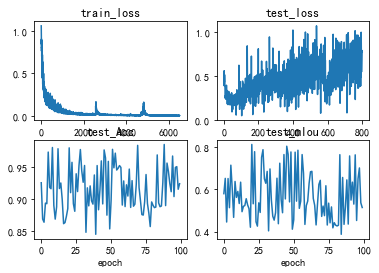

In [14]:
### 利用torchvision提供的transform，定义原始图片的预处理步骤（转换为tensor和标准化处理）
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.35, 0.38, 0.36], std=[0.29, 0.30, 0.32])])
# 实例化数据集
road_data = RoadDataset(transform)

train_size = int(0.9 * len(road_data))
test_size = len(road_data) - train_size
train_dataset, test_dataset = random_split(road_data, [train_size, test_size])

# 利用DataLoader生成一个分batch获取数据的可迭代对象
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True)
vgg_model = VGGNet(requires_grad=False,show_params=False)
# # 仅采用FCN8s进行训练
fcn_model = FCN8s(pretrained_net=vgg_model, n_class=3)
train(fcn_model,epo_num=100)

In [15]:
# 定义预测函数
def predict(data,model):
    model.eval()
    for road, road_msk in data:
        output = model(road)
        output_np = output.detach().numpy().copy()
        output_np = np.argmax(output_np, axis=1)
        road_msk_np = road_msk.detach().numpy().copy()

        for road_single,road_msk_single,output_single in zip(road,road_msk_np,output_np):
            plt.figure()
            plt.subplot(131)
            plt.title('predict')
            plt.imshow(output_single)
            plt.subplot(132)
            plt.title('mask')
            plt.imshow(road_msk_single)
            plt.subplot(133)
            plt.title('ground_truth')
            plt.imshow(road_single.numpy().transpose(1, 2, 0))
            plt.show()
        break


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


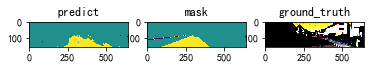

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


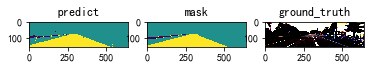

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


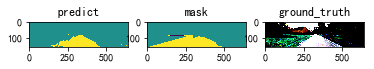

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


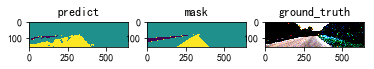

In [16]:
# 预测
vgg_model = VGGNet(requires_grad=False)
fcn_model = FCN8s(pretrained_net=vgg_model, n_class=3)
model_path='./checkpoints/fcn_model_100.pth'
fcn_model.load_state_dict(torch.load(model_path))
predict(test_dataloader,fcn_model)

In [ ]:
# # 微调
# # vgg_model = VGGNet(requires_grad=False)
# # fcn_model = FCN8s(pretrained_net=vgg_model, n_class=2)
# model_path='./fcn_model_100.pth'
# fcn_model.load_state_dict(torch.load(model_path))
# train(fcn_model,epo_num=200)